# CHAPTER 10

Introduction to Articial Neural Networks with Keras

- Building an Image Classier Using the Sequential API
- Compiling the Model
- Training and Evaluating the Model
- Building Complex Models Using the Functional API
    - One input
    - Multi input
    
All models using callbacks to save best model paramters and restore that models
- Saving and Restoring a Model
- Using Callbacks
- Visualization Using TensorBoard
- Fine-Tuning Neural Network Hyperparameters

### Use this command in terminal to see our tensorboard for visualization after run the notebook
- $ **tensorboard --logdir=./tensor_logs --port=6006**

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import os
import cv2
import sys
import matplotlib.image as mpimg
from PIL import Image
import scipy
from scipy import ndimage
from scipy.stats import reciprocal
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse
import time
import pickle
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Keras APIs
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras import models
from tensorflow import keras
import tensorflow as tf

from configs import *
from keras_sequential_model import *
from keras_functional_model import *
from all_ch11_models import *
warnings.filterwarnings('ignore')
%matplotlib inline


# Build Tensor Visualization

Keras provide us with tensor vislization a helpfull tool(can be used with your web browser or even in the notebook), this tool help us see the different runs we have made and see the result of training model during each epochs.

Beside of that we need to save the best parameters on the validation set in each run, to decide which run we will use later in our APIS, to make prediction.

## Get 100 * 100 images

100
I have 351 image of me
I have 346 image of others
Now total number of images is 697
The shape of y is:  (1, 697)
===================Before===================
(600, 30000)
(97, 30000)
(1, 600)
(1, 97)
===================After===================
(30000, 600)
(30000, 97)
(1, 600)
(1, 97)


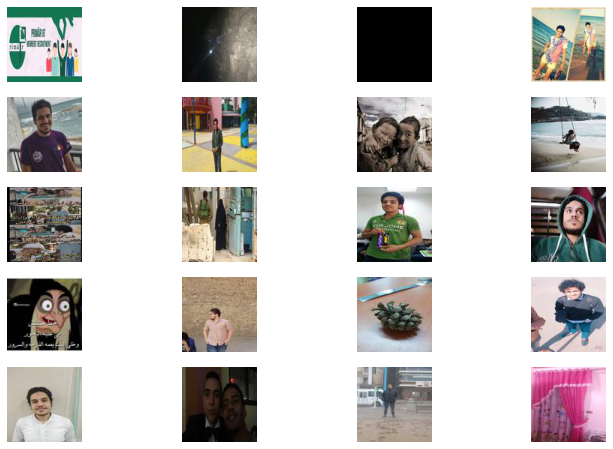

In [2]:
df_all_images = images_pipeline(300, "_300_300_3/")
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)
display_some_images(X_train, 300)

## Split the data

In [3]:
X_train, X_val, y_train, y_val = X_train.T, X_val.T, y_train.T, y_val.T
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3)

## Search for the best hyper paramters

In [4]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[X_train.shape[1]]):
    '''
    The function used to help us searching for best hyper paramters using sklearn along with keras.
    other optional parameters we can pass like metrics.

    Argument:
        n_hidden      : How many hidden layers we need
        n_neurons     : For each hidden layer which number of neurons we need (fixed number for all hidden layers)
        learning_rate : How to control the steps the model take during training
        input_shape   : The number of features we have defined by the image (width * height * 3 for rgb)
    
    return:
        model: The architecture of the model we have built and compiled 
    '''
        
     # Create the Sequential model
    model = keras.models.Sequential()
     # define the shape of the input layer from the features we have for each image
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
     # loop over hidden layers
    for i in range(n_hidden):
        
        # for each hidden layer pass the number of neurons for this layer
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
        
    # at the end handle the output layer as we just need to predict image belong to me or not so its just one unit
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=keras.optimizers.SGD(lr=learning_rate), metrics=['acc'])
    return model

## First Search

In [5]:
param_distribs = {
     "n_hidden": [1, 2, 3],
     "n_neurons": np.arange(50, 200),
     "learning_rate": reciprocal(3e-3, 1e0), # 3e-3 is 0.003 and 2e0 means 2.0
}

n_iter=5
rnd_search_cv = random_search(param_distribs, build_model, n_iter, X_train, y_train, X_val, y_val)



Epoch 1/100
13/13 [==============================] - 1s 30ms/step - loss: 0.6893 - acc: 0.5500 - val_loss: 0.7694 - val_acc: 0.4478
Epoch 2/100
13/13 [==============================] - 0s 17ms/step - loss: 0.6666 - acc: 0.5975 - val_loss: 0.8169 - val_acc: 0.4478
Epoch 3/100
13/13 [==============================] - 0s 17ms/step - loss: 0.6455 - acc: 0.6350 - val_loss: 0.7199 - val_acc: 0.4627
Epoch 4/100
13/13 [==============================] - 0s 17ms/step - loss: 0.6283 - acc: 0.6425 - val_loss: 0.7078 - val_acc: 0.5373
Epoch 5/100
13/13 [==============================] - 0s 18ms/step - loss: 0.6178 - acc: 0.6600 - val_loss: 0.7312 - val_acc: 0.5075
Epoch 6/100
13/13 [==============================] - 0s 17ms/step - loss: 0.6205 - acc: 0.6625 - val_loss: 0.6726 - val_acc: 0.6418
Epoch 7/100
13/13 [==============================] - 0s 17ms/step - loss: 0.5875 - acc: 0.7050 - val_loss: 0.6766 - val_acc: 0.6119
Epoch 8/100
13/13 [==============================] - 0s 16ms/step - loss: 0.

13/13 [==============================] - 0s 22ms/step - loss: 0.5409 - acc: 0.7375 - val_loss: 0.6940 - val_acc: 0.6119
Epoch 15/100
13/13 [==============================] - 0s 22ms/step - loss: 0.5350 - acc: 0.7250 - val_loss: 1.0728 - val_acc: 0.4478
Epoch 16/100
13/13 [==============================] - 0s 24ms/step - loss: 0.5428 - acc: 0.7400 - val_loss: 0.7060 - val_acc: 0.5224
Epoch 17/100
13/13 [==============================] - 0s 22ms/step - loss: 0.5580 - acc: 0.7200 - val_loss: 1.0363 - val_acc: 0.4328
Epoch 18/100
13/13 [==============================] - 0s 22ms/step - loss: 0.5112 - acc: 0.7600 - val_loss: 0.6740 - val_acc: 0.6269
Epoch 19/100
13/13 [==============================] - 0s 24ms/step - loss: 0.5406 - acc: 0.7650 - val_loss: 0.7016 - val_acc: 0.5522
Epoch 20/100
13/13 [==============================] - 0s 22ms/step - loss: 0.4847 - acc: 0.8050 - val_loss: 0.8015 - val_acc: 0.5522
Epoch 21/100
13/13 [==============================] - 0s 23ms/step - loss: 0.4837 

13/13 [==============================] - 0s 15ms/step - loss: 0.6142 - acc: 0.6725 - val_loss: 0.6898 - val_acc: 0.6119
Epoch 12/100
13/13 [==============================] - 0s 16ms/step - loss: 0.6101 - acc: 0.6575 - val_loss: 0.7622 - val_acc: 0.5224
Epoch 13/100
13/13 [==============================] - 0s 14ms/step - loss: 0.5995 - acc: 0.6800 - val_loss: 0.8314 - val_acc: 0.5522
Epoch 14/100
13/13 [==============================] - 0s 14ms/step - loss: 0.6475 - acc: 0.6625 - val_loss: 0.8058 - val_acc: 0.4328
Epoch 15/100
13/13 [==============================] - 0s 14ms/step - loss: 0.6144 - acc: 0.6825 - val_loss: 0.6933 - val_acc: 0.5522
Epoch 16/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6236 - acc: 0.6700
Epoch 1/100
13/13 [==============================] - 1s 23ms/step - loss: 0.8414 - acc: 0.5200 - val_loss: 0.7671 - val_acc: 0.4627
Epoch 2/100
13/13 [==============================] - 0s 14ms/step - loss: 0.6984 - acc: 0.5375 - val_loss: 0.6824 - val_acc

19/19 [==============================] - 0s 19ms/step - loss: 0.5461 - acc: 0.7583 - val_loss: 0.7767 - val_acc: 0.5224
Epoch 13/100
19/19 [==============================] - 0s 22ms/step - loss: 0.5774 - acc: 0.7033 - val_loss: 0.7068 - val_acc: 0.5970
Epoch 14/100
19/19 [==============================] - 0s 16ms/step - loss: 0.5544 - acc: 0.7283 - val_loss: 0.6968 - val_acc: 0.6119
Epoch 15/100
19/19 [==============================] - 0s 16ms/step - loss: 0.5214 - acc: 0.7617 - val_loss: 0.7644 - val_acc: 0.5522
Epoch 16/100
19/19 [==============================] - 0s 16ms/step - loss: 0.5269 - acc: 0.7383 - val_loss: 0.8175 - val_acc: 0.5224
Epoch 17/100
19/19 [==============================] - 0s 16ms/step - loss: 0.5043 - acc: 0.7700 - val_loss: 0.6669 - val_acc: 0.6567
Epoch 18/100
19/19 [==============================] - 0s 16ms/step - loss: 0.4893 - acc: 0.7983 - val_loss: 0.6826 - val_acc: 0.6418
Epoch 19/100
19/19 [==============================] - 0s 17ms/step - loss: 0.5094 

In [6]:
 rnd_search_cv.best_params_

{'learning_rate': 0.004216707536335725, 'n_hidden': 2, 'n_neurons': 128}

## Building an Image Classier Using the Sequential API

In [7]:
model, history, model_hyper_params = train_sequential_model_with_best_params(rnd_search_cv, X_train, y_train,
                                                                             X_val, y_val, "img_size_300*300*3_")

Epoch 1/100
19/19 [==============================] - 1s 23ms/step - loss: 0.6984 - acc: 0.5617 - val_loss: 0.6775 - val_acc: 0.5373
Epoch 2/100
19/19 [==============================] - 0s 16ms/step - loss: 0.6600 - acc: 0.6000 - val_loss: 0.6758 - val_acc: 0.5672
Epoch 3/100
19/19 [==============================] - 0s 15ms/step - loss: 0.6535 - acc: 0.6167 - val_loss: 0.6853 - val_acc: 0.5522
Epoch 4/100
19/19 [==============================] - 0s 15ms/step - loss: 0.6324 - acc: 0.6667 - val_loss: 0.7356 - val_acc: 0.5224
Epoch 5/100
19/19 [==============================] - 0s 15ms/step - loss: 0.6065 - acc: 0.6900 - val_loss: 0.7099 - val_acc: 0.5821
Epoch 6/100
19/19 [==============================] - 0s 16ms/step - loss: 0.5881 - acc: 0.7200 - val_loss: 0.7749 - val_acc: 0.5672
Epoch 7/100
19/19 [==============================] - 0s 16ms/step - loss: 0.6346 - acc: 0.6417 - val_loss: 0.6743 - val_acc: 0.5970
Epoch 8/100
19/19 [==============================] - 0s 16ms/step - loss: 0.

In [8]:
model = save_model_best_weights(model, model_hyper_params)
model.evaluate(X_val, y_val)

3/3 [==============================] - 0s 5ms/step - loss: 0.6658 - acc: 0.5821


[0.6657530069351196, 0.5820895433425903]

## Building Complex Models Using the Functional API (one Input)

In [9]:
model, history, model_hyper_params = train_functional_model_with_best_params(rnd_search_cv, X_train, y_train, 
             X_val, y_val, "one_input_functional_api",  img_size="img_size_300*300*3_")

Epoch 1/100
19/19 [==============================] - 1s 35ms/step - loss: 3.0337 - accuracy: 0.5067 - val_loss: 1.4271 - val_accuracy: 0.5672
Epoch 2/100
19/19 [==============================] - 0s 26ms/step - loss: 3.5465 - accuracy: 0.5067 - val_loss: 1.4886 - val_accuracy: 0.5672
Epoch 3/100
19/19 [==============================] - 0s 19ms/step - loss: 2.2718 - accuracy: 0.5400 - val_loss: 2.0733 - val_accuracy: 0.5522
Epoch 4/100
19/19 [==============================] - 0s 25ms/step - loss: 2.2001 - accuracy: 0.5817 - val_loss: 2.3277 - val_accuracy: 0.5522
Epoch 5/100
19/19 [==============================] - 0s 19ms/step - loss: 2.7734 - accuracy: 0.5550 - val_loss: 2.2869 - val_accuracy: 0.4478
Epoch 6/100
19/19 [==============================] - 0s 24ms/step - loss: 1.9972 - accuracy: 0.5967 - val_loss: 2.6221 - val_accuracy: 0.5522
Epoch 7/100
19/19 [==============================] - 0s 20ms/step - loss: 2.4650 - accuracy: 0.5767 - val_loss: 4.7723 - val_accuracy: 0.4478
Epoch 

In [10]:
model = save_model_best_weights(model, model_hyper_params)
model.evaluate(X_val, y_val)

3/3 [==============================] - 0s 6ms/step - loss: 1.1442 - accuracy: 0.6269


[1.1442114114761353, 0.6268656849861145]

## Building Complex Models Using the Functional API (multi Input)

In [11]:
model, history, model_hyper_params = train_functional_model_with_best_params(rnd_search_cv, X_train, y_train, 
             X_val, y_val, "multi_input_functional_api",  img_size="img_size_300*300*3_")

Epoch 1/100
19/19 [==============================] - 1s 28ms/step - loss: 1.1933 - accuracy: 0.5283 - val_loss: 0.9550 - val_accuracy: 0.4030
Epoch 2/100
19/19 [==============================] - 0s 17ms/step - loss: 1.0886 - accuracy: 0.5250 - val_loss: 0.7534 - val_accuracy: 0.5373
Epoch 3/100
19/19 [==============================] - 0s 18ms/step - loss: 1.0807 - accuracy: 0.5450 - val_loss: 0.8289 - val_accuracy: 0.4925
Epoch 4/100
19/19 [==============================] - 0s 17ms/step - loss: 0.9720 - accuracy: 0.5867 - val_loss: 0.8501 - val_accuracy: 0.5373
Epoch 5/100
19/19 [==============================] - 0s 18ms/step - loss: 0.8119 - accuracy: 0.6167 - val_loss: 1.0171 - val_accuracy: 0.4478
Epoch 6/100
19/19 [==============================] - 0s 18ms/step - loss: 0.8104 - accuracy: 0.6350 - val_loss: 2.4139 - val_accuracy: 0.4627
Epoch 7/100
19/19 [==============================] - 0s 18ms/step - loss: 0.9805 - accuracy: 0.6100 - val_loss: 0.9665 - val_accuracy: 0.4627
Epoch 

In [12]:
input_shape_A   = int(X_train.shape[1] / 3) 
X_val_A, X_val_B     = X_val[:, :input_shape_A], X_val
model.evaluate((X_val_A, X_val_B), y_val)

3/3 [==============================] - 0s 6ms/step - loss: 0.7534 - accuracy: 0.5373


[0.7534282207489014, 0.5373134613037109]

In [13]:
model = save_model_best_weights(model, model_hyper_params)

# CHAPTER 11

Training Deep Neural Networks

- Different initialization with different activation function

<img src="images/1.png">

- Batch Normalization before and after activation function
- Faster Optimizers
    - Momentum Optimization
    - Nesterov Accelerated Gradient
    - RMSProp
    - Adam and Nadam Optimization

- Learning Rate Scheduling
    - Power scheduling
    - Exponential scheduling
    - Piecewise constant scheduling
    - Performance scheduling
- Avoiding Overtting Through Regularization
    - ℓ1 and ℓ2 regularization
    - Dropout

<img src="images/de_init.png">

## SGD No Batch Normalizing & No regularization
- Exponential Learning Rate
- Relu, LeakyRelu, PRelu, ELU & he_normal 

In [14]:
n_hidden      = rnd_search_cv.best_params_['n_hidden']
n_neurons     = rnd_search_cv.best_params_['n_neurons']
learning_rate = rnd_search_cv.best_params_['learning_rate']
img_size      = "img_size_300*300*3_"
input_shape   = [X_train.shape[1]]
exponential_decay_fn = exponential_decay(lr0=learning_rate, s=10)
exp_lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)


In [15]:
act_relu  = keras.layers.ReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD()
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_no_batch_no_regularize_relu_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 29ms/step - loss: 0.7222 - accuracy: 0.5567 - val_loss: 0.6923 - val_accuracy: 0.5373
Epoch 2/50
19/19 [==============================] - 0s 18ms/step - loss: 0.6562 - accuracy: 0.6167 - val_loss: 0.6833 - val_accuracy: 0.6119
Epoch 3/50
19/19 [==============================] - 0s 18ms/step - loss: 0.6392 - accuracy: 0.6650 - val_loss: 0.6977 - val_accuracy: 0.6119
Epoch 4/50
19/19 [==============================] - 0s 18ms/step - loss: 0.6253 - accuracy: 0.6783 - val_loss: 0.7735 - val_accuracy: 0.4179
Epoch 5/50
19/19 [==============================] - 0s 17ms/step - loss: 0.6122 - accuracy: 0.6750 - val_loss: 0.7175 - val_accuracy: 0.5522
Epoch 6/50
19/19 [==============================] - 0s 19ms/step - loss: 0.5956 - accuracy: 0.6950 - val_loss: 0.6898 - val_accuracy: 0.5821
Epoch 7/50
19/19 [==============================] - 0s 16ms/step - loss: 0.5750 - accuracy: 0.7183 - val_loss: 0.7312 - val_accuracy: 0.5373
Restoring mod

In [16]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 5ms/step - loss: 0.6833 - accuracy: 0.6119
[0.6832585334777832, 0.611940324306488]


In [17]:
act_relu  = keras.layers.LeakyReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD()
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_no_batch_no_regularize_LeakyReLU_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 23ms/step - loss: 0.8415 - accuracy: 0.5250 - val_loss: 0.6880 - val_accuracy: 0.5075
Epoch 2/50
19/19 [==============================] - 0s 17ms/step - loss: 0.6627 - accuracy: 0.5867 - val_loss: 0.6933 - val_accuracy: 0.5373
Epoch 3/50
19/19 [==============================] - 0s 17ms/step - loss: 0.6318 - accuracy: 0.6783 - val_loss: 0.7037 - val_accuracy: 0.5224
Epoch 4/50
19/19 [==============================] - 0s 16ms/step - loss: 0.6256 - accuracy: 0.6650 - val_loss: 0.7350 - val_accuracy: 0.5522
Epoch 5/50
19/19 [==============================] - 0s 16ms/step - loss: 0.6058 - accuracy: 0.7083 - val_loss: 0.7927 - val_accuracy: 0.4776
Epoch 6/50
19/19 [==============================] - 0s 16ms/step - loss: 0.6042 - accuracy: 0.6800 - val_loss: 0.6980 - val_accuracy: 0.5522
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


In [18]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 6ms/step - loss: 0.6880 - accuracy: 0.5075
[0.6879746913909912, 0.5074626803398132]


In [19]:
act_relu  = keras.layers.PReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD()
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_no_batch_no_regularize_PReLU_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 25ms/step - loss: 0.7643 - accuracy: 0.5450 - val_loss: 0.6953 - val_accuracy: 0.4925
Epoch 2/50
19/19 [==============================] - 0s 17ms/step - loss: 0.6639 - accuracy: 0.6300 - val_loss: 0.8128 - val_accuracy: 0.4328
Epoch 3/50
19/19 [==============================] - 0s 18ms/step - loss: 0.6509 - accuracy: 0.6300 - val_loss: 0.7593 - val_accuracy: 0.4030
Epoch 4/50
19/19 [==============================] - 0s 18ms/step - loss: 0.6313 - accuracy: 0.6633 - val_loss: 0.6994 - val_accuracy: 0.4925
Epoch 5/50
19/19 [==============================] - 0s 18ms/step - loss: 0.6140 - accuracy: 0.6983 - val_loss: 0.7024 - val_accuracy: 0.5224
Epoch 6/50
19/19 [==============================] - 0s 18ms/step - loss: 0.5968 - accuracy: 0.7033 - val_loss: 0.7177 - val_accuracy: 0.5224
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


In [20]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 6ms/step - loss: 0.6953 - accuracy: 0.4925
[0.6953396797180176, 0.49253731966018677]


In [21]:
act_relu  = keras.layers.ELU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD()
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_no_batch_no_regularize_ELU_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 23ms/step - loss: 0.8949 - accuracy: 0.5400 - val_loss: 0.7826 - val_accuracy: 0.4328
Epoch 2/50
19/19 [==============================] - 0s 17ms/step - loss: 0.6476 - accuracy: 0.6167 - val_loss: 0.6915 - val_accuracy: 0.5672
Epoch 3/50
19/19 [==============================] - 0s 18ms/step - loss: 0.6328 - accuracy: 0.6500 - val_loss: 0.6848 - val_accuracy: 0.5970
Epoch 4/50
19/19 [==============================] - 0s 17ms/step - loss: 0.6201 - accuracy: 0.6717 - val_loss: 0.6810 - val_accuracy: 0.5970
Epoch 5/50
19/19 [==============================] - 0s 18ms/step - loss: 0.6019 - accuracy: 0.6983 - val_loss: 0.7301 - val_accuracy: 0.5373
Epoch 6/50
19/19 [==============================] - 0s 18ms/step - loss: 0.5910 - accuracy: 0.6967 - val_loss: 0.6897 - val_accuracy: 0.5821
Epoch 7/50
19/19 [==============================] - 0s 17ms/step - loss: 0.5841 - accuracy: 0.7083 - val_loss: 0.7272 - val_accuracy: 0.5522
Epoch 8/50
19

In [22]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 5ms/step - loss: 0.6810 - accuracy: 0.5970
[0.6810473203659058, 0.5970149040222168]


## SGD with Batch Normalizing before Activation & No regularization
- Exponential Learning Rate
- Relu, LeakyRelu, PRelu, ELU & he_normal 

In [25]:
act_relu    = keras.layers.ReLU()
model     = with_batch_before_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD()
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_with_batch_before_no_regularize_Relu_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 41ms/step - loss: 0.6549 - accuracy: 0.6583 - val_loss: 0.7402 - val_accuracy: 0.5522
Epoch 2/50
19/19 [==============================] - 1s 29ms/step - loss: 0.4301 - accuracy: 0.8317 - val_loss: 0.7196 - val_accuracy: 0.5373
Epoch 3/50
19/19 [==============================] - 1s 33ms/step - loss: 0.3580 - accuracy: 0.8950 - val_loss: 0.7228 - val_accuracy: 0.5373
Epoch 4/50
19/19 [==============================] - 1s 35ms/step - loss: 0.3092 - accuracy: 0.9167 - val_loss: 0.7022 - val_accuracy: 0.5075
Epoch 5/50
19/19 [==============================] - 1s 28ms/step - loss: 0.2740 - accuracy: 0.9417 - val_loss: 0.7069 - val_accuracy: 0.5373
Epoch 6/50
19/19 [==============================] - 1s 30ms/step - loss: 0.2467 - accuracy: 0.9583 - val_loss: 0.6844 - val_accuracy: 0.5224
Epoch 7/50
19/19 [==============================] - 1s 31ms/step - loss: 0.2391 - accuracy: 0.9583 - val_loss: 0.6743 - val_accuracy: 0.5522
Epoch 8/50
19

In [26]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 7ms/step - loss: 0.6454 - accuracy: 0.6269
[0.6454221606254578, 0.6268656849861145]


In [28]:
act_relu    = keras.layers.LeakyReLU()
model     = with_batch_before_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD()
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_with_batch_before_no_regularize_LeakyRelu_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 40ms/step - loss: 0.7432 - accuracy: 0.6100 - val_loss: 1.1356 - val_accuracy: 0.4627
Epoch 2/50
19/19 [==============================] - 1s 28ms/step - loss: 0.5122 - accuracy: 0.7517 - val_loss: 0.7902 - val_accuracy: 0.4925
Epoch 3/50
19/19 [==============================] - 1s 27ms/step - loss: 0.4482 - accuracy: 0.7900 - val_loss: 0.8139 - val_accuracy: 0.4776
Epoch 4/50
19/19 [==============================] - 1s 28ms/step - loss: 0.3800 - accuracy: 0.8350 - val_loss: 0.6944 - val_accuracy: 0.5672
Epoch 5/50
19/19 [==============================] - 1s 34ms/step - loss: 0.3476 - accuracy: 0.8800 - val_loss: 0.7448 - val_accuracy: 0.5373
Epoch 6/50
19/19 [==============================] - 1s 28ms/step - loss: 0.3252 - accuracy: 0.8800 - val_loss: 0.7099 - val_accuracy: 0.5672
Epoch 7/50
19/19 [==============================] - 1s 27ms/step - loss: 0.2931 - accuracy: 0.9167 - val_loss: 0.6894 - val_accuracy: 0.5522
Epoch 8/50
19

In [29]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 7ms/step - loss: 0.6690 - accuracy: 0.5522
[0.6690027117729187, 0.5522388219833374]


In [30]:
act_relu    = keras.layers.PReLU()
model     = with_batch_before_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD()
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_with_batch_before_no_regularize_PRelu_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 2s 47ms/step - loss: 0.6434 - accuracy: 0.6367 - val_loss: 0.8114 - val_accuracy: 0.4925
Epoch 2/50
19/19 [==============================] - 1s 30ms/step - loss: 0.4557 - accuracy: 0.8217 - val_loss: 0.7383 - val_accuracy: 0.5373
Epoch 3/50
19/19 [==============================] - 1s 27ms/step - loss: 0.3832 - accuracy: 0.8733 - val_loss: 0.7025 - val_accuracy: 0.5672
Epoch 4/50
19/19 [==============================] - 1s 28ms/step - loss: 0.3229 - accuracy: 0.9200 - val_loss: 0.6987 - val_accuracy: 0.5821
Epoch 5/50
19/19 [==============================] - 1s 29ms/step - loss: 0.2881 - accuracy: 0.9283 - val_loss: 0.6824 - val_accuracy: 0.5821
Epoch 6/50
19/19 [==============================] - 1s 30ms/step - loss: 0.2690 - accuracy: 0.9533 - val_loss: 0.6865 - val_accuracy: 0.5672
Epoch 7/50
19/19 [==============================] - 1s 34ms/step - loss: 0.2450 - accuracy: 0.9483 - val_loss: 0.6667 - val_accuracy: 0.5970
Epoch 8/50
19

In [31]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 8ms/step - loss: 0.6150 - accuracy: 0.6567
[0.6149621605873108, 0.6567164063453674]


In [32]:
act_relu    = keras.layers.ELU()
model     = with_batch_before_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD()
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_with_batch_before_no_regularize_ELU_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 2s 54ms/step - loss: 0.6549 - accuracy: 0.6417 - val_loss: 0.8565 - val_accuracy: 0.4776
Epoch 2/50
19/19 [==============================] - 1s 37ms/step - loss: 0.4746 - accuracy: 0.7950 - val_loss: 0.8351 - val_accuracy: 0.4925
Epoch 3/50
19/19 [==============================] - 1s 29ms/step - loss: 0.4084 - accuracy: 0.8450 - val_loss: 0.7547 - val_accuracy: 0.5224
Epoch 4/50
19/19 [==============================] - 1s 30ms/step - loss: 0.3610 - accuracy: 0.8800 - val_loss: 0.7553 - val_accuracy: 0.5373
Epoch 5/50
19/19 [==============================] - 1s 32ms/step - loss: 0.3183 - accuracy: 0.9150 - val_loss: 0.7049 - val_accuracy: 0.5821
Epoch 6/50
19/19 [==============================] - 1s 28ms/step - loss: 0.2975 - accuracy: 0.9100 - val_loss: 0.7324 - val_accuracy: 0.5672
Epoch 7/50
19/19 [==============================] - 1s 29ms/step - loss: 0.2795 - accuracy: 0.9183 - val_loss: 0.7022 - val_accuracy: 0.5970
Epoch 8/50
19

In [33]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 6ms/step - loss: 0.6997 - accuracy: 0.5970
[0.6996598839759827, 0.5970149040222168]


## SGD with Batch Normalizing after Activation & No regularization
- Exponential Learning Rate
- Relu, LeakyRelu, PRelu, ELU & he_normal 

In [34]:
act_relu    = keras.layers.ELU()
model     = with_batch_after_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD()
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_with_batch_after_no_regularize_ELU_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 40ms/step - loss: 0.7018 - accuracy: 0.6417 - val_loss: 0.8658 - val_accuracy: 0.4627
Epoch 2/50
19/19 [==============================] - 1s 34ms/step - loss: 0.4131 - accuracy: 0.8233 - val_loss: 0.7511 - val_accuracy: 0.5522
Epoch 3/50
19/19 [==============================] - 1s 28ms/step - loss: 0.3262 - accuracy: 0.8750 - val_loss: 0.7775 - val_accuracy: 0.5224
Epoch 4/50
19/19 [==============================] - 1s 29ms/step - loss: 0.2724 - accuracy: 0.9150 - val_loss: 0.7732 - val_accuracy: 0.5373
Epoch 5/50
19/19 [==============================] - 1s 33ms/step - loss: 0.2527 - accuracy: 0.9200 - val_loss: 0.7344 - val_accuracy: 0.5821
Epoch 6/50
19/19 [==============================] - 1s 33ms/step - loss: 0.2114 - accuracy: 0.9500 - val_loss: 0.7217 - val_accuracy: 0.6269
Epoch 7/50
19/19 [==============================] - 1s 27ms/step - loss: 0.1995 - accuracy: 0.9600 - val_loss: 0.7646 - val_accuracy: 0.5970
Epoch 8/50
19

In [35]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 7ms/step - loss: 0.7217 - accuracy: 0.6269
[0.7216840982437134, 0.6268656849861145]


## SGD No Batch Normalizing & No regularization
- Performance Learning Rate
- Relu, LeakyRelu, PRelu, ELU & he_normal 

In [36]:
performance_lr = keras.callbacks.ReduceLROnPlateau(factor=.5, patience=5)

In [37]:
act_relu  = keras.layers.ReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD(lr=learning_rate)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_no_batch_no_regularize_ReLU_performance_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(performance_lr)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 25ms/step - loss: 0.7611 - accuracy: 0.5167 - val_loss: 0.7231 - val_accuracy: 0.4627
Epoch 2/50
19/19 [==============================] - 0s 17ms/step - loss: 0.6659 - accuracy: 0.6150 - val_loss: 0.7267 - val_accuracy: 0.4627
Epoch 3/50
19/19 [==============================] - 0s 15ms/step - loss: 0.6674 - accuracy: 0.6117 - val_loss: 0.6725 - val_accuracy: 0.5970
Epoch 4/50
19/19 [==============================] - 0s 16ms/step - loss: 0.6270 - accuracy: 0.6683 - val_loss: 0.8174 - val_accuracy: 0.4328
Epoch 5/50
19/19 [==============================] - 0s 15ms/step - loss: 0.6205 - accuracy: 0.6767 - val_loss: 0.7670 - val_accuracy: 0.4627
Epoch 6/50
19/19 [==============================] - 0s 17ms/step - loss: 0.6127 - accuracy: 0.6733 - val_loss: 0.8228 - val_accuracy: 0.4328
Epoch 7/50
19/19 [==============================] - 0s 15ms/step - loss: 0.6282 - accuracy: 0.6583 - val_loss: 0.7502 - val_accuracy: 0.4925
Epoch 8/50
19

In [38]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 7ms/step - loss: 0.6725 - accuracy: 0.5970
[0.6725464463233948, 0.5970149040222168]


In [39]:
act_relu  = keras.layers.LeakyReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD(lr=learning_rate)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_no_batch_no_regularize_LeakyReLU_performance_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(performance_lr)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 23ms/step - loss: 0.8026 - accuracy: 0.5567 - val_loss: 0.7159 - val_accuracy: 0.4776
Epoch 2/50
19/19 [==============================] - 0s 17ms/step - loss: 0.6654 - accuracy: 0.6133 - val_loss: 0.7660 - val_accuracy: 0.5821
Epoch 3/50
19/19 [==============================] - 0s 16ms/step - loss: 0.6276 - accuracy: 0.6533 - val_loss: 0.8210 - val_accuracy: 0.4328
Epoch 4/50
19/19 [==============================] - 0s 17ms/step - loss: 0.6343 - accuracy: 0.6700 - val_loss: 0.6938 - val_accuracy: 0.5373
Epoch 5/50
19/19 [==============================] - 0s 18ms/step - loss: 0.6585 - accuracy: 0.6367 - val_loss: 0.7591 - val_accuracy: 0.4776
Epoch 6/50
19/19 [==============================] - 0s 17ms/step - loss: 0.6069 - accuracy: 0.6717 - val_loss: 0.7130 - val_accuracy: 0.5970
Epoch 7/50
19/19 [==============================] - 0s 18ms/step - loss: 0.6133 - accuracy: 0.6833 - val_loss: 0.7857 - val_accuracy: 0.6119
Epoch 8/50
19

In [40]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.5373
[0.6938176155090332, 0.5373134613037109]


In [41]:
act_relu  = keras.layers.PReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD(lr=learning_rate)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_no_batch_no_regularize_PReLU_performance_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(performance_lr)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 27ms/step - loss: 0.7572 - accuracy: 0.5533 - val_loss: 0.7113 - val_accuracy: 0.4627
Epoch 2/50
19/19 [==============================] - 0s 16ms/step - loss: 0.6756 - accuracy: 0.5967 - val_loss: 0.7033 - val_accuracy: 0.5075
Epoch 3/50
19/19 [==============================] - 0s 22ms/step - loss: 0.6555 - accuracy: 0.6150 - val_loss: 0.7609 - val_accuracy: 0.4030
Epoch 4/50
19/19 [==============================] - 0s 16ms/step - loss: 0.6423 - accuracy: 0.6433 - val_loss: 0.7407 - val_accuracy: 0.4328
Epoch 5/50
19/19 [==============================] - 0s 21ms/step - loss: 0.6549 - accuracy: 0.6500 - val_loss: 0.7701 - val_accuracy: 0.4179
Epoch 6/50
19/19 [==============================] - 0s 20ms/step - loss: 0.6270 - accuracy: 0.6733 - val_loss: 0.6987 - val_accuracy: 0.5821
Epoch 7/50
19/19 [==============================] - 0s 16ms/step - loss: 0.5995 - accuracy: 0.6950 - val_loss: 0.7986 - val_accuracy: 0.4328
Epoch 8/50
19

In [42]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 5ms/step - loss: 0.6987 - accuracy: 0.5821
[0.6987025141716003, 0.5820895433425903]


In [43]:
act_relu  = keras.layers.ELU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD(lr=learning_rate)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_no_batch_no_regularize_ELU_performance_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(performance_lr)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 30ms/step - loss: 0.9275 - accuracy: 0.5250 - val_loss: 0.8908 - val_accuracy: 0.4478
Epoch 2/50
19/19 [==============================] - 0s 18ms/step - loss: 0.6472 - accuracy: 0.6367 - val_loss: 0.6629 - val_accuracy: 0.5821
Epoch 3/50
19/19 [==============================] - 0s 20ms/step - loss: 0.6303 - accuracy: 0.6400 - val_loss: 0.9038 - val_accuracy: 0.4627
Epoch 4/50
19/19 [==============================] - 0s 17ms/step - loss: 0.6403 - accuracy: 0.6250 - val_loss: 0.6539 - val_accuracy: 0.6567
Epoch 5/50
19/19 [==============================] - 0s 19ms/step - loss: 0.6148 - accuracy: 0.6650 - val_loss: 0.6723 - val_accuracy: 0.6418
Epoch 6/50
19/19 [==============================] - 0s 19ms/step - loss: 0.5898 - accuracy: 0.6900 - val_loss: 0.6619 - val_accuracy: 0.6418
Epoch 7/50
19/19 [==============================] - 0s 16ms/step - loss: 0.5799 - accuracy: 0.6933 - val_loss: 0.6719 - val_accuracy: 0.6567
Epoch 8/50
19

In [44]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 5ms/step - loss: 0.6395 - accuracy: 0.6269
[0.63953697681427, 0.6268656849861145]


## SGD with Batch Normalizing before and after activation & No regularization
- Performance Learning Rate
- ELU & he_normal 

In [45]:
performance_lr = keras.callbacks.ReduceLROnPlateau(factor=.5, patience=5)

In [46]:
act_relu    = keras.layers.ELU()
model     = with_batch_before_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD()
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_with_batch_before_no_regularize_ELU_performance_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(performance_lr)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 43ms/step - loss: 0.7130 - accuracy: 0.6433 - val_loss: 0.8721 - val_accuracy: 0.4478
Epoch 2/50
19/19 [==============================] - 1s 35ms/step - loss: 0.4744 - accuracy: 0.7867 - val_loss: 0.7736 - val_accuracy: 0.5075
Epoch 3/50
19/19 [==============================] - 1s 30ms/step - loss: 0.4036 - accuracy: 0.8267 - val_loss: 1.1129 - val_accuracy: 0.4179
Epoch 4/50
19/19 [==============================] - 1s 31ms/step - loss: 0.3379 - accuracy: 0.8717 - val_loss: 0.7871 - val_accuracy: 0.5075
Epoch 5/50
19/19 [==============================] - 1s 27ms/step - loss: 0.2907 - accuracy: 0.9017 - val_loss: 0.7099 - val_accuracy: 0.5970
Epoch 6/50
19/19 [==============================] - 1s 29ms/step - loss: 0.2579 - accuracy: 0.9267 - val_loss: 0.7981 - val_accuracy: 0.5522
Epoch 7/50
19/19 [==============================] - 1s 28ms/step - loss: 0.2320 - accuracy: 0.9300 - val_loss: 0.8509 - val_accuracy: 0.4776
Epoch 8/50
19

In [47]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 6ms/step - loss: 0.7099 - accuracy: 0.5970
[0.7098784446716309, 0.5970149040222168]


In [48]:
act_relu    = keras.layers.ELU()
model     = with_batch_after_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.SGD()
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_sgd_with_batch_after_no_regularize_ELU_performance_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(performance_lr)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 40ms/step - loss: 0.6964 - accuracy: 0.6367 - val_loss: 1.1128 - val_accuracy: 0.4478
Epoch 2/50
19/19 [==============================] - 1s 29ms/step - loss: 0.4385 - accuracy: 0.8067 - val_loss: 0.7952 - val_accuracy: 0.5522
Epoch 3/50
19/19 [==============================] - 1s 31ms/step - loss: 0.3634 - accuracy: 0.8567 - val_loss: 0.7895 - val_accuracy: 0.5672
Epoch 4/50
19/19 [==============================] - 1s 30ms/step - loss: 0.3134 - accuracy: 0.8817 - val_loss: 0.8297 - val_accuracy: 0.5373
Epoch 5/50
19/19 [==============================] - 1s 29ms/step - loss: 0.2724 - accuracy: 0.9033 - val_loss: 0.7708 - val_accuracy: 0.5821
Epoch 6/50
19/19 [==============================] - 1s 30ms/step - loss: 0.2147 - accuracy: 0.9300 - val_loss: 0.7806 - val_accuracy: 0.5970
Epoch 7/50
19/19 [==============================] - 1s 36ms/step - loss: 0.1767 - accuracy: 0.9433 - val_loss: 0.8534 - val_accuracy: 0.5672
Epoch 8/50
19

In [49]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 7ms/step - loss: 0.7708 - accuracy: 0.5821
[0.7708298563957214, 0.5820895433425903]


## RMSprop No Batch Normalizing & No regularization
- Exponential Learning Rate
- Relu, LeakyRelu, PRelu, ELU & he_normal 

In [50]:
exponential_decay_fn = exponential_decay(lr0=learning_rate, s=10)
exp_lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)


In [51]:

act_relu  = keras.layers.ReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.RMSprop(rho=.9)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_RMSprop_no_batch_no_regularize_relu_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)


Epoch 1/50
19/19 [==============================] - 1s 47ms/step - loss: 41.3544 - accuracy: 0.5200 - val_loss: 7.2376 - val_accuracy: 0.4627
Epoch 2/50
19/19 [==============================] - 1s 39ms/step - loss: 5.4996 - accuracy: 0.5000 - val_loss: 4.4371 - val_accuracy: 0.4627
Epoch 3/50
19/19 [==============================] - 1s 37ms/step - loss: 1.2944 - accuracy: 0.5267 - val_loss: 1.0175 - val_accuracy: 0.5224
Epoch 4/50
19/19 [==============================] - 1s 37ms/step - loss: 0.9526 - accuracy: 0.5333 - val_loss: 0.6805 - val_accuracy: 0.5224
Epoch 5/50
19/19 [==============================] - 1s 37ms/step - loss: 0.7284 - accuracy: 0.5600 - val_loss: 0.6912 - val_accuracy: 0.5672
Epoch 6/50
19/19 [==============================] - 1s 37ms/step - loss: 0.7923 - accuracy: 0.5633 - val_loss: 0.7567 - val_accuracy: 0.4776
Epoch 7/50
19/19 [==============================] - 1s 38ms/step - loss: 0.6881 - accuracy: 0.5733 - val_loss: 0.7405 - val_accuracy: 0.5522
Epoch 8/50
1

In [52]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 8ms/step - loss: 0.6805 - accuracy: 0.5224
[0.6805460453033447, 0.5223880410194397]


In [53]:

act_relu  = keras.layers.LeakyReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.RMSprop(rho=.9)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_RMSprop_no_batch_no_regularize_LeakyReLU_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)


Epoch 1/50
19/19 [==============================] - 1s 48ms/step - loss: 195.4962 - accuracy: 0.5050 - val_loss: 87.9039 - val_accuracy: 0.4328
Epoch 2/50
19/19 [==============================] - 1s 38ms/step - loss: 32.3301 - accuracy: 0.4700 - val_loss: 23.2822 - val_accuracy: 0.4328
Epoch 3/50
19/19 [==============================] - 1s 37ms/step - loss: 14.2902 - accuracy: 0.5083 - val_loss: 31.9195 - val_accuracy: 0.5672
Epoch 4/50
19/19 [==============================] - 1s 45ms/step - loss: 10.7922 - accuracy: 0.5233 - val_loss: 5.9357 - val_accuracy: 0.5672
Epoch 5/50
19/19 [==============================] - 1s 37ms/step - loss: 8.7247 - accuracy: 0.5483 - val_loss: 1.8852 - val_accuracy: 0.5821
Epoch 6/50
19/19 [==============================] - 1s 38ms/step - loss: 4.7565 - accuracy: 0.5400 - val_loss: 5.2884 - val_accuracy: 0.5672
Epoch 7/50
19/19 [==============================] - 1s 39ms/step - loss: 2.1730 - accuracy: 0.6083 - val_loss: 3.0347 - val_accuracy: 0.5821
Epoch

In [54]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 6ms/step - loss: 0.7799 - accuracy: 0.6567
[0.7798540592193604, 0.6567164063453674]


In [55]:

act_relu  = keras.layers.PReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.RMSprop(rho=.9)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_RMSprop_no_batch_no_regularize_PReLU_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)


Epoch 1/50
19/19 [==============================] - 2s 49ms/step - loss: 97.5398 - accuracy: 0.5217 - val_loss: 30.9195 - val_accuracy: 0.5672
Epoch 2/50
19/19 [==============================] - 1s 39ms/step - loss: 18.8735 - accuracy: 0.5117 - val_loss: 1.2934 - val_accuracy: 0.4627
Epoch 3/50
19/19 [==============================] - 1s 40ms/step - loss: 8.8945 - accuracy: 0.5333 - val_loss: 15.1727 - val_accuracy: 0.5672
Epoch 4/50
19/19 [==============================] - 1s 39ms/step - loss: 4.9884 - accuracy: 0.5383 - val_loss: 6.6387 - val_accuracy: 0.4627
Epoch 5/50
19/19 [==============================] - 1s 39ms/step - loss: 4.1777 - accuracy: 0.5167 - val_loss: 12.3222 - val_accuracy: 0.4627
Epoch 6/50
19/19 [==============================] - 1s 42ms/step - loss: 3.5131 - accuracy: 0.5383 - val_loss: 1.3998 - val_accuracy: 0.5672
Epoch 7/50
19/19 [==============================] - 1s 42ms/step - loss: 1.0176 - accuracy: 0.5517 - val_loss: 2.6531 - val_accuracy: 0.4328
Restorin

In [56]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 5ms/step - loss: 1.2934 - accuracy: 0.4627
[1.2933622598648071, 0.46268656849861145]


In [57]:

act_relu  = keras.layers.ELU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.RMSprop(rho=.9)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_RMSprop_no_batch_no_regularize_ELU_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)


Epoch 1/50
19/19 [==============================] - 1s 48ms/step - loss: 50.7356 - accuracy: 0.5083 - val_loss: 0.9768 - val_accuracy: 0.5672
Epoch 2/50
19/19 [==============================] - 1s 41ms/step - loss: 3.2842 - accuracy: 0.5483 - val_loss: 1.1369 - val_accuracy: 0.5821
Epoch 3/50
19/19 [==============================] - 1s 40ms/step - loss: 1.3120 - accuracy: 0.5417 - val_loss: 0.7034 - val_accuracy: 0.5970
Epoch 4/50
19/19 [==============================] - 1s 39ms/step - loss: 0.9979 - accuracy: 0.5550 - val_loss: 1.9167 - val_accuracy: 0.4627
Epoch 5/50
19/19 [==============================] - 1s 51ms/step - loss: 0.9724 - accuracy: 0.5450 - val_loss: 0.8072 - val_accuracy: 0.5821
Epoch 6/50
19/19 [==============================] - 1s 41ms/step - loss: 0.9154 - accuracy: 0.6100 - val_loss: 0.7787 - val_accuracy: 0.5970
Epoch 7/50
19/19 [==============================] - 1s 37ms/step - loss: 0.6701 - accuracy: 0.6167 - val_loss: 0.9837 - val_accuracy: 0.4179
Epoch 8/50
1

In [58]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 5ms/step - loss: 0.7034 - accuracy: 0.5970
[0.7033765912055969, 0.5970149040222168]


## RMSprop with Batch Normalizing before and after activation function & No regularization
- Exponential Learning Rate
- ELU & he_normal 

In [59]:

act_relu  = keras.layers.ELU()
model     = with_batch_before_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.RMSprop(rho=.9)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_RMSprop_with_batch_before_no_regularize_ELU_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)


Epoch 1/50
19/19 [==============================] - 2s 68ms/step - loss: 0.7536 - accuracy: 0.6050 - val_loss: 0.7181 - val_accuracy: 0.5672
Epoch 2/50
19/19 [==============================] - 1s 55ms/step - loss: 0.5559 - accuracy: 0.7283 - val_loss: 1.0642 - val_accuracy: 0.4328
Epoch 3/50
19/19 [==============================] - 1s 48ms/step - loss: 0.4988 - accuracy: 0.7600 - val_loss: 0.7645 - val_accuracy: 0.5373
Epoch 4/50
19/19 [==============================] - 1s 47ms/step - loss: 0.4175 - accuracy: 0.8083 - val_loss: 0.7095 - val_accuracy: 0.5970
Epoch 5/50
19/19 [==============================] - 1s 53ms/step - loss: 0.3422 - accuracy: 0.8583 - val_loss: 1.4886 - val_accuracy: 0.4478
Epoch 6/50
19/19 [==============================] - 1s 51ms/step - loss: 0.2592 - accuracy: 0.8900 - val_loss: 1.0217 - val_accuracy: 0.5373
Epoch 7/50
19/19 [==============================] - 1s 49ms/step - loss: 0.1983 - accuracy: 0.9283 - val_loss: 0.8601 - val_accuracy: 0.5672
Epoch 8/50
19

In [60]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 7ms/step - loss: 0.7095 - accuracy: 0.5970
[0.7095431089401245, 0.5970149040222168]


In [61]:

act_relu  = keras.layers.ELU()
model     = with_batch_after_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.RMSprop(rho=.9)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_RMSprop_with_batch_after_no_regularize_ELU_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)


Epoch 1/50
19/19 [==============================] - 2s 59ms/step - loss: 0.7781 - accuracy: 0.6183 - val_loss: 1.9235 - val_accuracy: 0.4328
Epoch 2/50
19/19 [==============================] - 1s 54ms/step - loss: 0.5541 - accuracy: 0.7333 - val_loss: 1.3732 - val_accuracy: 0.4478
Epoch 3/50
19/19 [==============================] - 1s 47ms/step - loss: 0.4483 - accuracy: 0.7867 - val_loss: 1.5355 - val_accuracy: 0.5075
Epoch 4/50
19/19 [==============================] - 1s 44ms/step - loss: 0.3305 - accuracy: 0.8533 - val_loss: 0.9569 - val_accuracy: 0.6269
Epoch 5/50
19/19 [==============================] - 1s 47ms/step - loss: 0.2758 - accuracy: 0.8883 - val_loss: 0.9917 - val_accuracy: 0.5075
Epoch 6/50
19/19 [==============================] - 1s 46ms/step - loss: 0.1937 - accuracy: 0.9283 - val_loss: 0.9165 - val_accuracy: 0.5672
Epoch 7/50
19/19 [==============================] - 1s 45ms/step - loss: 0.1387 - accuracy: 0.9583 - val_loss: 1.3477 - val_accuracy: 0.5075
Epoch 8/50
19

In [62]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 6ms/step - loss: 0.8950 - accuracy: 0.6418
[0.8949685096740723, 0.641791045665741]


## RMSprop No Batch Normalizing & No regularization
- Performance Learning Rate
- Relu, LeakyRelu, PRelu, ELU & he_normal 

In [63]:
performance_lr = keras.callbacks.ReduceLROnPlateau(factor=.5, patience=5)

In [64]:
act_relu  = keras.layers.ReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.RMSprop(lr=learning_rate, rho=.9)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_RMSprop_no_batch_no_regularize_ReLU_performance_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(performance_lr)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 49ms/step - loss: 52.1815 - accuracy: 0.5250 - val_loss: 9.2393 - val_accuracy: 0.5672
Epoch 2/50
19/19 [==============================] - 1s 39ms/step - loss: 4.7622 - accuracy: 0.4917 - val_loss: 2.1186 - val_accuracy: 0.5672
Epoch 3/50
19/19 [==============================] - 1s 37ms/step - loss: 2.2331 - accuracy: 0.5017 - val_loss: 0.6867 - val_accuracy: 0.4627
Epoch 4/50
19/19 [==============================] - 1s 39ms/step - loss: 0.9254 - accuracy: 0.5167 - val_loss: 0.6737 - val_accuracy: 0.5821
Epoch 5/50
19/19 [==============================] - 1s 37ms/step - loss: 0.7321 - accuracy: 0.5033 - val_loss: 0.6801 - val_accuracy: 0.4627
Epoch 6/50
19/19 [==============================] - 1s 51ms/step - loss: 0.8373 - accuracy: 0.5483 - val_loss: 7.2533 - val_accuracy: 0.5672
Epoch 7/50
19/19 [==============================] - 1s 53ms/step - loss: 1.0683 - accuracy: 0.5567 - val_loss: 0.6835 - val_accuracy: 0.4627
Epoch 8/50
1

In [65]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 5ms/step - loss: 0.6737 - accuracy: 0.5821
[0.6737167239189148, 0.5820895433425903]


In [66]:
act_relu  = keras.layers.LeakyReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.RMSprop(lr=learning_rate, rho=.9)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_RMSprop_no_batch_no_regularize_LeakyReLU_performance_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(performance_lr)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 2s 53ms/step - loss: 130.1289 - accuracy: 0.5417 - val_loss: 20.1588 - val_accuracy: 0.5672
Epoch 2/50
19/19 [==============================] - 1s 40ms/step - loss: 32.2663 - accuracy: 0.5133 - val_loss: 14.0403 - val_accuracy: 0.5672
Epoch 3/50
19/19 [==============================] - 1s 38ms/step - loss: 37.8519 - accuracy: 0.4983 - val_loss: 4.7853 - val_accuracy: 0.5821
Epoch 4/50
19/19 [==============================] - 1s 38ms/step - loss: 25.6969 - accuracy: 0.4783 - val_loss: 10.0559 - val_accuracy: 0.5672
Epoch 5/50
19/19 [==============================] - 1s 47ms/step - loss: 14.8554 - accuracy: 0.5300 - val_loss: 43.7089 - val_accuracy: 0.4627
Epoch 6/50
19/19 [==============================] - 1s 38ms/step - loss: 26.2081 - accuracy: 0.5217 - val_loss: 15.7681 - val_accuracy: 0.4627
Epoch 7/50
19/19 [==============================] - 1s 36ms/step - loss: 12.2196 - accuracy: 0.5317 - val_loss: 2.1550 - val_accuracy: 0.5672


In [67]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 8ms/step - loss: 2.1550 - accuracy: 0.5672
[2.15497088432312, 0.5671641826629639]


In [68]:
act_relu  = keras.layers.PReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.RMSprop(lr=learning_rate, rho=.9)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_RMSprop_no_batch_no_regularize_PReLU_performance_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(performance_lr)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 43ms/step - loss: 61.4895 - accuracy: 0.4817 - val_loss: 15.2061 - val_accuracy: 0.4627
Epoch 2/50
19/19 [==============================] - 1s 39ms/step - loss: 11.3380 - accuracy: 0.5350 - val_loss: 3.5468 - val_accuracy: 0.4627
Epoch 3/50
19/19 [==============================] - 1s 37ms/step - loss: 10.9361 - accuracy: 0.5017 - val_loss: 10.5594 - val_accuracy: 0.4627
Epoch 4/50
19/19 [==============================] - 1s 50ms/step - loss: 13.4487 - accuracy: 0.5300 - val_loss: 39.1794 - val_accuracy: 0.5672
Epoch 5/50
19/19 [==============================] - 1s 49ms/step - loss: 13.9945 - accuracy: 0.5050 - val_loss: 8.1275 - val_accuracy: 0.4627
Epoch 6/50
19/19 [==============================] - 1s 51ms/step - loss: 9.4917 - accuracy: 0.5217 - val_loss: 9.8264 - val_accuracy: 0.4627
Epoch 7/50
19/19 [==============================] - 1s 52ms/step - loss: 9.5481 - accuracy: 0.4867 - val_loss: 17.4942 - val_accuracy: 0.4627
Rest

In [69]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 4ms/step - loss: 3.5468 - accuracy: 0.4627
[3.546849489212036, 0.46268656849861145]


In [70]:
act_relu  = keras.layers.ELU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.RMSprop(lr=learning_rate, rho=.9)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_RMSprop_no_batch_no_regularize_ELU_performance_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(performance_lr)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 49ms/step - loss: 89.3060 - accuracy: 0.5283 - val_loss: 0.9514 - val_accuracy: 0.5075
Epoch 2/50
19/19 [==============================] - 1s 34ms/step - loss: 12.4553 - accuracy: 0.4983 - val_loss: 5.0573 - val_accuracy: 0.5672
Epoch 3/50
19/19 [==============================] - 1s 32ms/step - loss: 3.4346 - accuracy: 0.5250 - val_loss: 0.6845 - val_accuracy: 0.5373
Epoch 4/50
19/19 [==============================] - 1s 38ms/step - loss: 1.3230 - accuracy: 0.5300 - val_loss: 0.8396 - val_accuracy: 0.4627
Epoch 5/50
19/19 [==============================] - 1s 36ms/step - loss: 4.9230 - accuracy: 0.5117 - val_loss: 1.0610 - val_accuracy: 0.4627
Epoch 6/50
19/19 [==============================] - 1s 36ms/step - loss: 1.8933 - accuracy: 0.5400 - val_loss: 0.6865 - val_accuracy: 0.5821
Epoch 7/50
19/19 [==============================] - 1s 37ms/step - loss: 0.8362 - accuracy: 0.5417 - val_loss: 0.7159 - val_accuracy: 0.5373
Epoch 8/50


In [71]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 6ms/step - loss: 0.6845 - accuracy: 0.5373
[0.6845042109489441, 0.5373134613037109]


## Adam No Batch Normalizing & No regularization
- Exponential Learning Rate
- Relu, LeakyRelu, PRelu, ELU & he_normal 

In [72]:
exponential_decay_fn = exponential_decay(lr0=learning_rate, s=10)
exp_lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [73]:
act_relu  = keras.layers.ReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_Adam_no_batch_no_regularize_ReLU_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 40ms/step - loss: 20.7166 - accuracy: 0.4867 - val_loss: 4.9368 - val_accuracy: 0.4627
Epoch 2/50
19/19 [==============================] - 1s 27ms/step - loss: 1.2191 - accuracy: 0.5867 - val_loss: 1.1498 - val_accuracy: 0.5672
Epoch 3/50
19/19 [==============================] - 1s 30ms/step - loss: 2.2042 - accuracy: 0.5250 - val_loss: 1.5473 - val_accuracy: 0.5672
Epoch 4/50
19/19 [==============================] - 1s 35ms/step - loss: 1.3544 - accuracy: 0.5767 - val_loss: 1.5132 - val_accuracy: 0.5522
Epoch 5/50
19/19 [==============================] - 1s 33ms/step - loss: 0.9674 - accuracy: 0.6233 - val_loss: 0.9648 - val_accuracy: 0.5373
Epoch 6/50
19/19 [==============================] - 1s 33ms/step - loss: 0.7416 - accuracy: 0.6433 - val_loss: 0.8710 - val_accuracy: 0.5821
Epoch 7/50
19/19 [==============================] - 1s 36ms/step - loss: 0.6609 - accuracy: 0.6617 - val_loss: 0.7693 - val_accuracy: 0.6269
Epoch 8/50
1

In [74]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 6ms/step - loss: 0.7693 - accuracy: 0.6269
[0.7692863345146179, 0.6268656849861145]


In [75]:
act_relu  = keras.layers.LeakyReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_Adam_no_batch_no_regularize_LeakyReLU_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 2s 51ms/step - loss: 21.5640 - accuracy: 0.5250 - val_loss: 13.3029 - val_accuracy: 0.4627
Epoch 2/50
19/19 [==============================] - 1s 31ms/step - loss: 5.0093 - accuracy: 0.5533 - val_loss: 10.7781 - val_accuracy: 0.4627
Epoch 3/50
19/19 [==============================] - 1s 33ms/step - loss: 3.0940 - accuracy: 0.5967 - val_loss: 4.6526 - val_accuracy: 0.4478
Epoch 4/50
19/19 [==============================] - 1s 29ms/step - loss: 1.9052 - accuracy: 0.6300 - val_loss: 1.5081 - val_accuracy: 0.5821
Epoch 5/50
19/19 [==============================] - 1s 31ms/step - loss: 0.7749 - accuracy: 0.7150 - val_loss: 1.7230 - val_accuracy: 0.4925
Epoch 6/50
19/19 [==============================] - 1s 35ms/step - loss: 0.7051 - accuracy: 0.7217 - val_loss: 0.8954 - val_accuracy: 0.5821
Epoch 7/50
19/19 [==============================] - 1s 26ms/step - loss: 0.5022 - accuracy: 0.7650 - val_loss: 0.8854 - val_accuracy: 0.5373
Epoch 8/50

In [76]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 11ms/step - loss: 0.8070 - accuracy: 0.6119
[0.8069583177566528, 0.611940324306488]


In [77]:
act_relu  = keras.layers.PReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_Adam_no_batch_no_regularize_PReLU_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 2s 46ms/step - loss: 16.5756 - accuracy: 0.4983 - val_loss: 5.6784 - val_accuracy: 0.5672
Epoch 2/50
19/19 [==============================] - 1s 34ms/step - loss: 4.2463 - accuracy: 0.5050 - val_loss: 0.9535 - val_accuracy: 0.5373
Epoch 3/50
19/19 [==============================] - 0s 25ms/step - loss: 1.3877 - accuracy: 0.5700 - val_loss: 0.8480 - val_accuracy: 0.5373
Epoch 4/50
19/19 [==============================] - 1s 30ms/step - loss: 0.6817 - accuracy: 0.6533 - val_loss: 1.7449 - val_accuracy: 0.4328
Epoch 5/50
19/19 [==============================] - 1s 35ms/step - loss: 0.7832 - accuracy: 0.6050 - val_loss: 0.8314 - val_accuracy: 0.5373
Epoch 6/50
19/19 [==============================] - 1s 37ms/step - loss: 0.5514 - accuracy: 0.7017 - val_loss: 1.0019 - val_accuracy: 0.4925
Epoch 7/50
19/19 [==============================] - 1s 30ms/step - loss: 0.7165 - accuracy: 0.6317 - val_loss: 0.8766 - val_accuracy: 0.5522
Epoch 8/50
1

In [78]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 7ms/step - loss: 0.7353 - accuracy: 0.6269
[0.7352633476257324, 0.6268656849861145]


In [79]:
act_relu  = keras.layers.ELU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_Adam_no_batch_no_regularize_ELU_exponential_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(exp_lr_scheduler)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 30ms/step - loss: 15.6315 - accuracy: 0.4950 - val_loss: 19.3039 - val_accuracy: 0.4627
Epoch 2/50
19/19 [==============================] - 0s 23ms/step - loss: 6.7056 - accuracy: 0.5233 - val_loss: 7.6894 - val_accuracy: 0.4478
Epoch 3/50
19/19 [==============================] - 0s 24ms/step - loss: 3.7958 - accuracy: 0.6067 - val_loss: 1.6962 - val_accuracy: 0.5672
Epoch 4/50
19/19 [==============================] - 0s 22ms/step - loss: 1.2199 - accuracy: 0.6767 - val_loss: 1.2947 - val_accuracy: 0.5672
Epoch 5/50
19/19 [==============================] - 1s 31ms/step - loss: 0.7649 - accuracy: 0.7050 - val_loss: 0.8700 - val_accuracy: 0.5970
Epoch 6/50
19/19 [==============================] - 1s 32ms/step - loss: 0.5970 - accuracy: 0.7100 - val_loss: 0.8165 - val_accuracy: 0.6269
Epoch 7/50
19/19 [==============================] - 1s 26ms/step - loss: 0.5252 - accuracy: 0.7500 - val_loss: 0.8999 - val_accuracy: 0.5522
Epoch 8/50


In [80]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 9ms/step - loss: 0.7400 - accuracy: 0.6567
[0.7400206327438354, 0.6567164063453674]


## Adam No Batch Normalizing & No regularization
- Performance Learning Rate
- Relu, LeakyRelu, PRelu, ELU & he_normal 

In [81]:
performance_lr = keras.callbacks.ReduceLROnPlateau(factor=.5, patience=5)

In [82]:
act_relu  = keras.layers.ReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_Adam_no_batch_no_regularize_ReLU_performance_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(performance_lr)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 44ms/step - loss: 4.0185 - accuracy: 0.5000 - val_loss: 2.6132 - val_accuracy: 0.4627
Epoch 2/50
19/19 [==============================] - 0s 21ms/step - loss: 1.1383 - accuracy: 0.5750 - val_loss: 1.0112 - val_accuracy: 0.5821
Epoch 3/50
19/19 [==============================] - 0s 23ms/step - loss: 0.7892 - accuracy: 0.6000 - val_loss: 0.8248 - val_accuracy: 0.5075
Epoch 4/50
19/19 [==============================] - 1s 28ms/step - loss: 0.6376 - accuracy: 0.6417 - val_loss: 0.7012 - val_accuracy: 0.5373
Epoch 5/50
19/19 [==============================] - 0s 23ms/step - loss: 0.6248 - accuracy: 0.6517 - val_loss: 0.8251 - val_accuracy: 0.5373
Epoch 6/50
19/19 [==============================] - 0s 21ms/step - loss: 0.5423 - accuracy: 0.7500 - val_loss: 0.9526 - val_accuracy: 0.5224
Epoch 7/50
19/19 [==============================] - 0s 25ms/step - loss: 0.5241 - accuracy: 0.7450 - val_loss: 0.9828 - val_accuracy: 0.4776
Epoch 8/50
19

In [83]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 8ms/step - loss: 0.7012 - accuracy: 0.5373
[0.7011563777923584, 0.5373134613037109]


In [84]:
act_relu  = keras.layers.LeakyReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_Adam_no_batch_no_regularize_LeakyReLU_performance_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(performance_lr)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 30ms/step - loss: 10.5899 - accuracy: 0.5100 - val_loss: 1.0377 - val_accuracy: 0.5522
Epoch 2/50
19/19 [==============================] - 0s 23ms/step - loss: 2.1115 - accuracy: 0.5633 - val_loss: 1.8343 - val_accuracy: 0.5522
Epoch 3/50
19/19 [==============================] - 0s 20ms/step - loss: 2.0469 - accuracy: 0.5367 - val_loss: 3.2809 - val_accuracy: 0.4179
Epoch 4/50
19/19 [==============================] - 0s 21ms/step - loss: 1.5011 - accuracy: 0.5967 - val_loss: 1.0554 - val_accuracy: 0.4925
Epoch 5/50
19/19 [==============================] - 0s 21ms/step - loss: 0.6301 - accuracy: 0.6967 - val_loss: 1.0372 - val_accuracy: 0.6119
Epoch 6/50
19/19 [==============================] - 0s 21ms/step - loss: 1.2633 - accuracy: 0.5583 - val_loss: 1.5283 - val_accuracy: 0.4925
Epoch 7/50
19/19 [==============================] - 0s 20ms/step - loss: 1.2384 - accuracy: 0.6283 - val_loss: 1.1179 - val_accuracy: 0.5373
Epoch 8/50
1

In [85]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 12ms/step - loss: 0.9286 - accuracy: 0.6269
[0.9285714626312256, 0.6268656849861145]


In [86]:
act_relu  = keras.layers.PReLU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_Adam_no_batch_no_regularize_PReLU_performance_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(performance_lr)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 42ms/step - loss: 6.5653 - accuracy: 0.4717 - val_loss: 1.3379 - val_accuracy: 0.4627
Epoch 2/50
19/19 [==============================] - 1s 27ms/step - loss: 1.5300 - accuracy: 0.5850 - val_loss: 2.3077 - val_accuracy: 0.4179
Epoch 3/50
19/19 [==============================] - 1s 38ms/step - loss: 1.5087 - accuracy: 0.5750 - val_loss: 1.1109 - val_accuracy: 0.6119
Epoch 4/50
19/19 [==============================] - 1s 37ms/step - loss: 0.7550 - accuracy: 0.6833 - val_loss: 0.8735 - val_accuracy: 0.5522
Epoch 5/50
19/19 [==============================] - 1s 32ms/step - loss: 0.5590 - accuracy: 0.7433 - val_loss: 1.0621 - val_accuracy: 0.5075
Epoch 6/50
19/19 [==============================] - 1s 30ms/step - loss: 0.6611 - accuracy: 0.6900 - val_loss: 0.8118 - val_accuracy: 0.6269
Epoch 7/50
19/19 [==============================] - 0s 25ms/step - loss: 0.5270 - accuracy: 0.7550 - val_loss: 0.7629 - val_accuracy: 0.6567
Epoch 8/50
19

In [87]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 6ms/step - loss: 0.7305 - accuracy: 0.6119
[0.7305022478103638, 0.611940324306488]


In [88]:
act_relu  = keras.layers.ELU()
model     = no_batch_seqential_model_create(input_shape, n_hidden, n_neurons, "he_normal", act_relu)
optimizer = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999)
model     = no_batch_seqential_model_compile(model, optimizer)

model_description = "ch11_Adam_no_batch_no_regularize_ELU_performance_lr"

model_hyper_params   = ch11_model_hyper_parameters(n_hidden, model_description,  img_size)
run_log_dir          = tensor_logs_dir(TENSOR_DIR, model_hyper_params)

# Append to its learning rate if you need
callbacks_           = ch11_call_backs(run_log_dir, patience=5)
callbacks_.append(performance_lr)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
                   callbacks=callbacks_)

Epoch 1/50
19/19 [==============================] - 1s 29ms/step - loss: 4.4064 - accuracy: 0.5200 - val_loss: 0.7743 - val_accuracy: 0.5672
Epoch 2/50
19/19 [==============================] - 0s 22ms/step - loss: 0.7352 - accuracy: 0.6167 - val_loss: 0.7260 - val_accuracy: 0.6418
Epoch 3/50
19/19 [==============================] - 0s 24ms/step - loss: 0.7171 - accuracy: 0.6150 - val_loss: 0.7436 - val_accuracy: 0.6269
Epoch 4/50
19/19 [==============================] - 0s 22ms/step - loss: 0.6673 - accuracy: 0.6450 - val_loss: 0.7124 - val_accuracy: 0.6119
Epoch 5/50
19/19 [==============================] - 1s 27ms/step - loss: 0.5671 - accuracy: 0.7150 - val_loss: 0.6950 - val_accuracy: 0.6269
Epoch 6/50
19/19 [==============================] - 0s 22ms/step - loss: 0.5276 - accuracy: 0.7400 - val_loss: 0.6920 - val_accuracy: 0.6418
Epoch 7/50
19/19 [==============================] - 0s 23ms/step - loss: 0.5227 - accuracy: 0.7233 - val_loss: 0.7447 - val_accuracy: 0.5672
Epoch 8/50
19

In [89]:
evalute = model.evaluate(X_val, y_val)
model_hyper_params += "_val_loss_is_" + str(np.round(evalute[0], 2)) + "_"
model = save_model_best_weights(model, model_hyper_params)
print(evalute)

3/3 [==============================] - 0s 6ms/step - loss: 0.6689 - accuracy: 0.6418
[0.668857216835022, 0.641791045665741]
